# Filter binder scaffolds and thread new target sequences

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_crispies
running on node: gpu38


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Load CSV of premade helix binder scaffolds

In [3]:
simulation_name = "03_fold_bound_states"
output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
)
scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [4]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [5]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

In [6]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

2701
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 'score_per_res', 'score_per_res_parent', 'seed', 'shift', 'ss_sc', 'state', 'time', 'tol', 'topo',

### Plot AF2 interdomain metrics

11it [00:00, 29.08it/s]


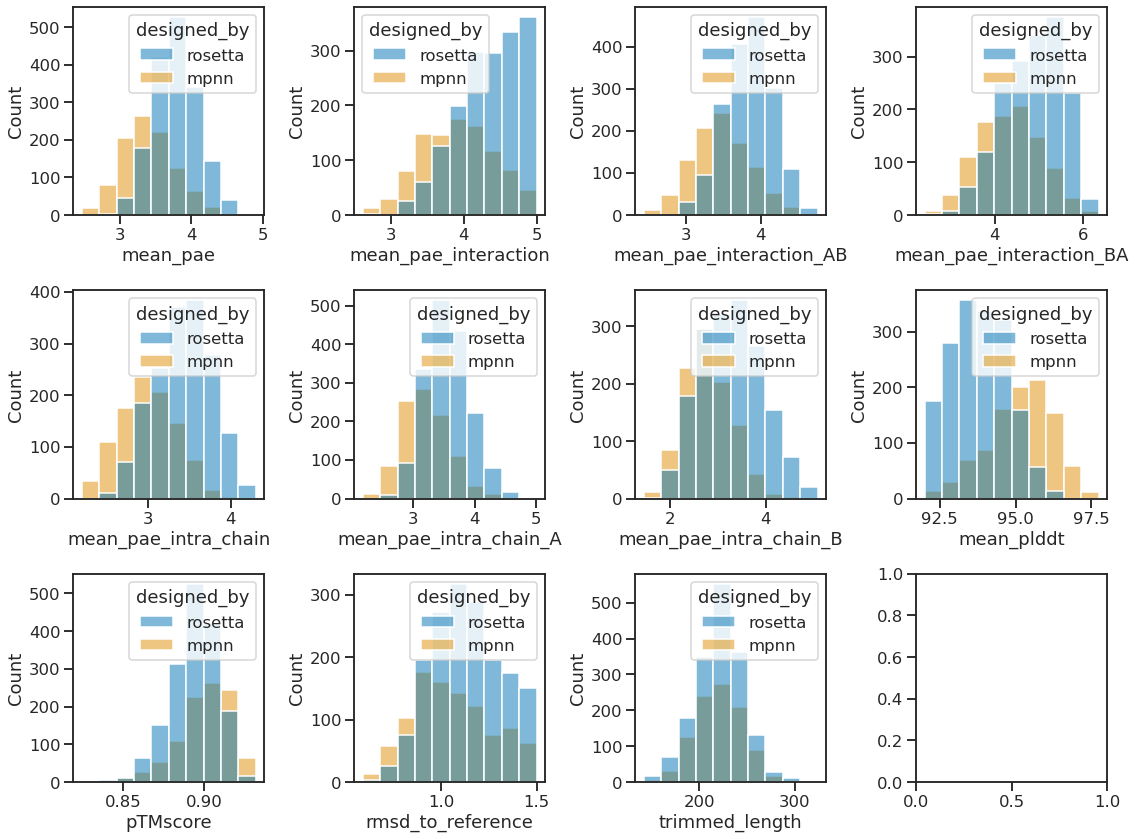

In [7]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
    "trimmed_length",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)

<Figure size 3168x3168 with 0 Axes>

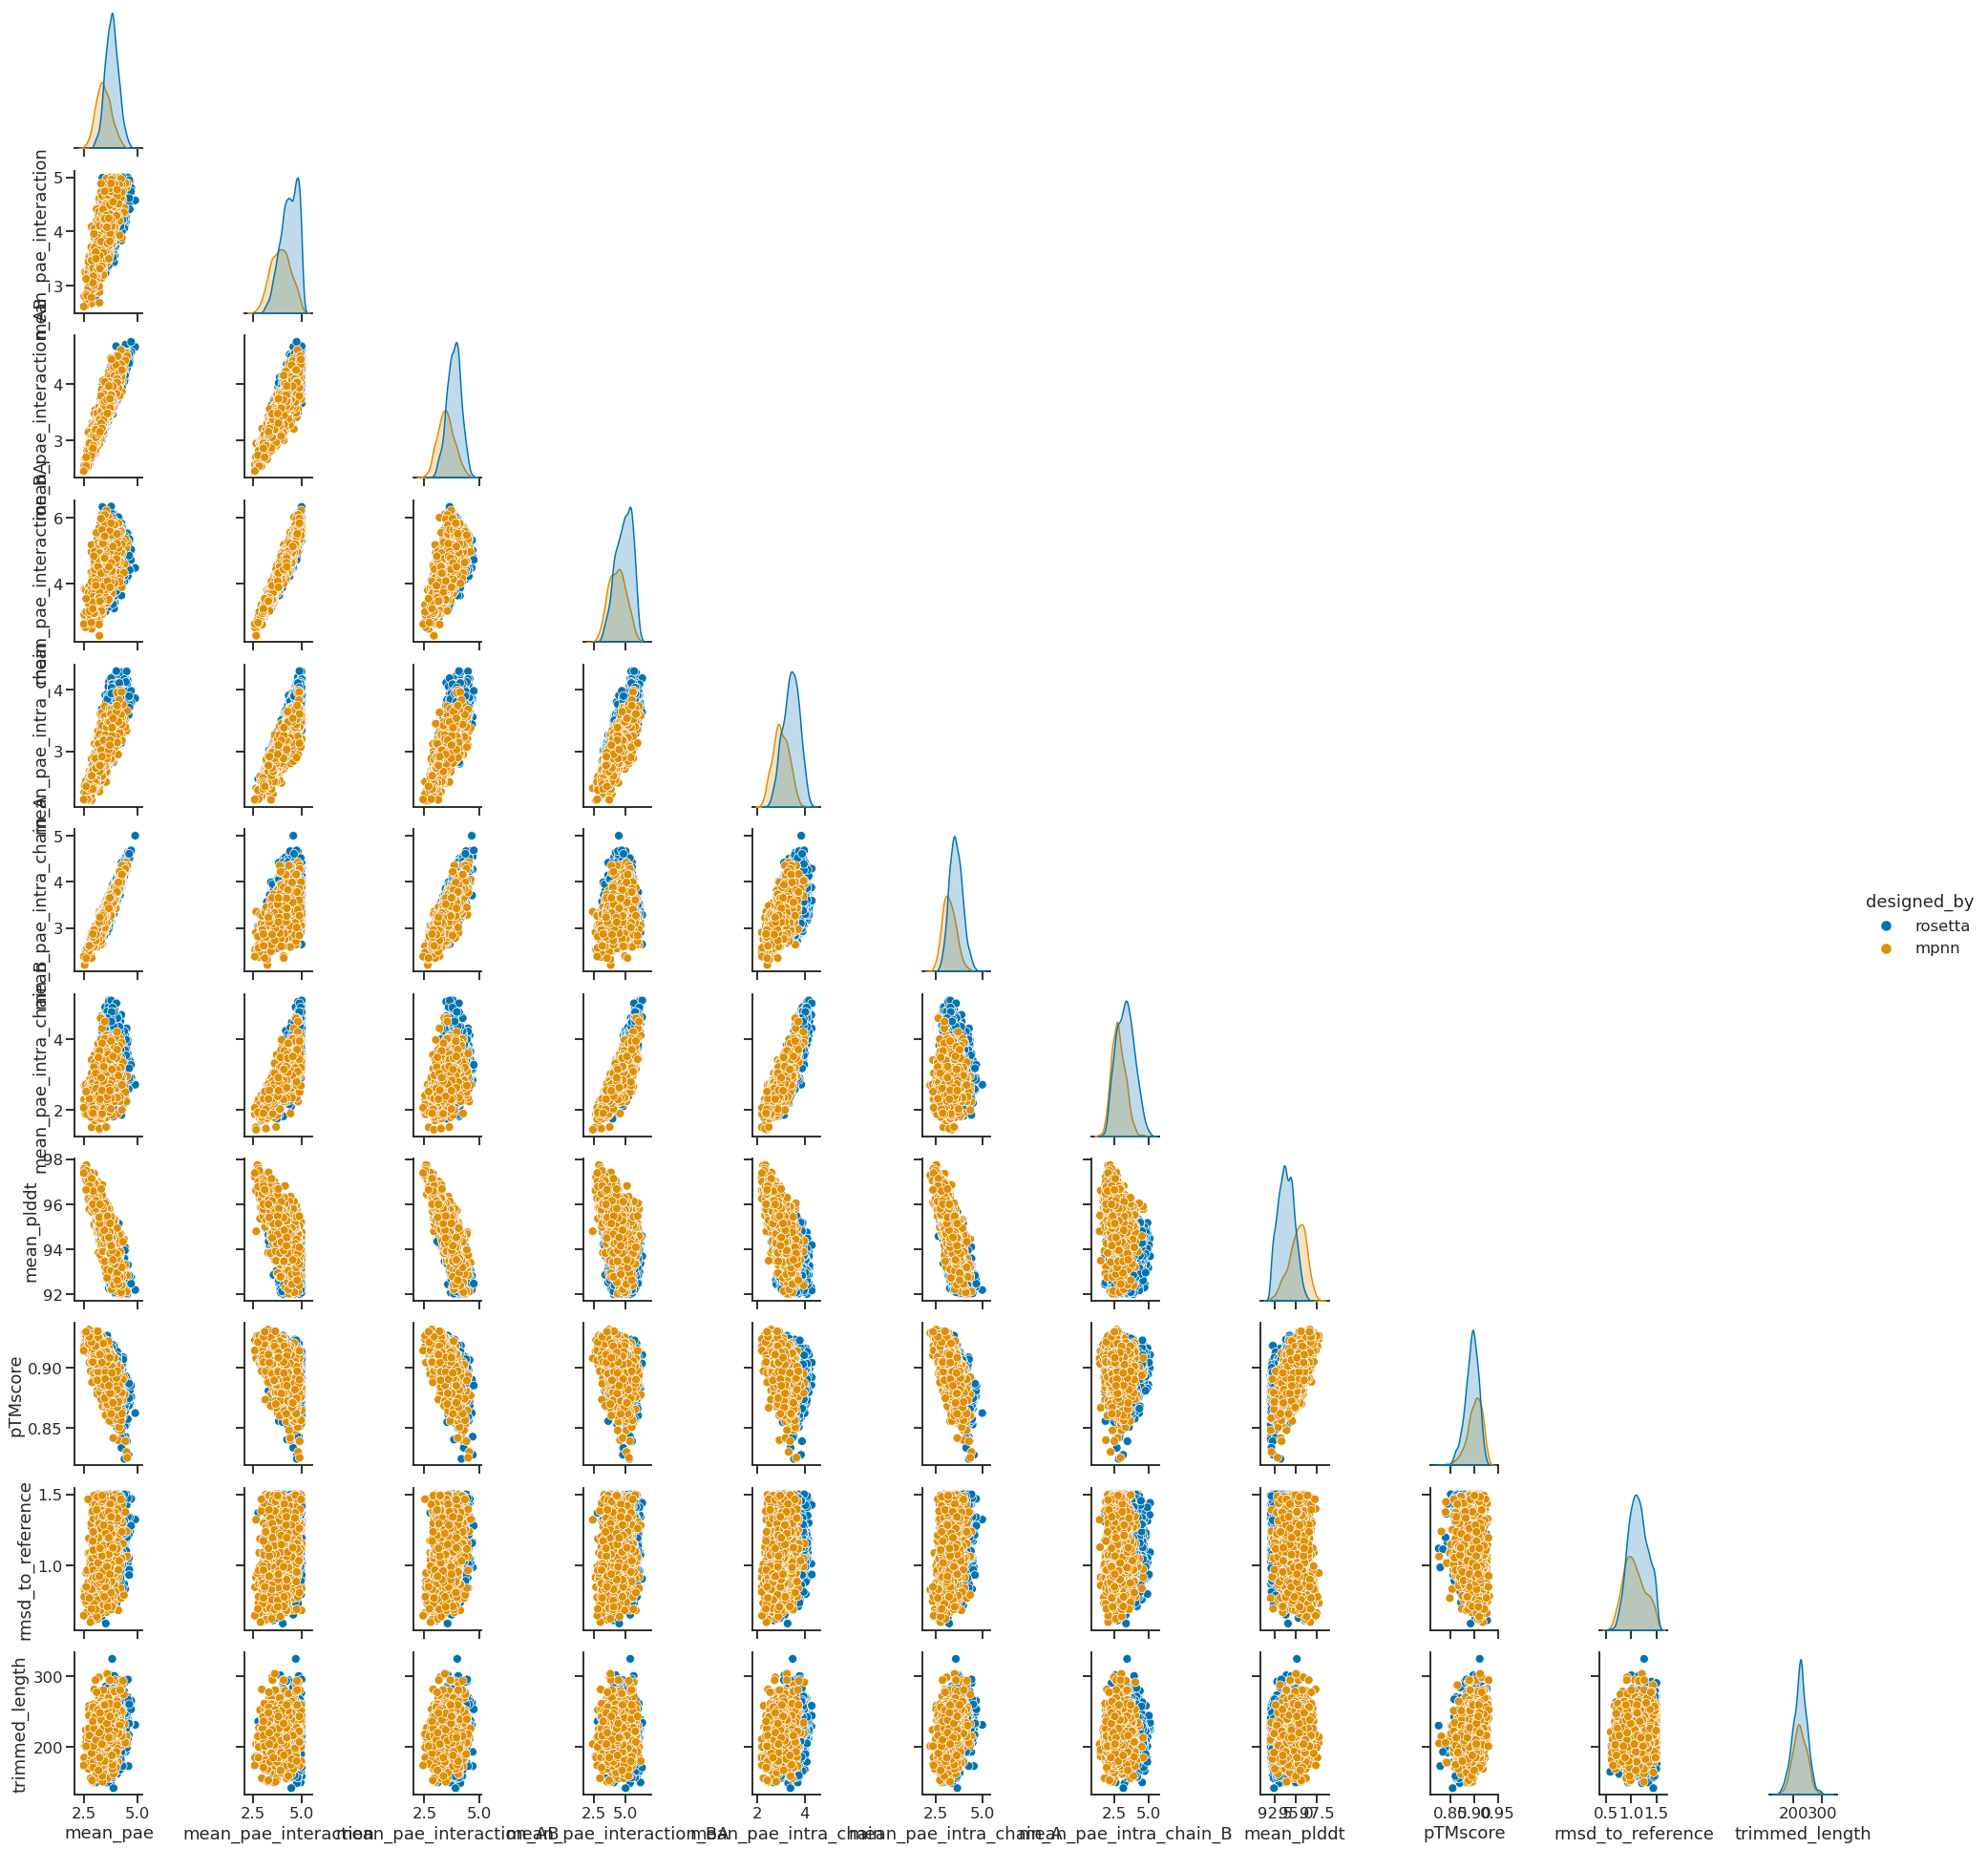

In [8]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

### Filter the whole df

In [9]:
query = """
    mean_plddt > 94 \
    and pTMscore > 0.9 \
    and mean_pae_intra_chain_A < 3 \
    and rmsd_to_reference < 1.25 \
    and trimmed_length < 240 \
"""

filtered = scores_df.query(query)
len(filtered)

227660

### Save a list of outputs
Sort by length  

In [10]:
simulation_name = "02_thread_targets"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
os.makedirs(output_path, exist_ok=True)
with open(os.path.join(output_path, "input_scaffolds.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

downsample = filtered.sample(int(1e5), random_state=0)
with open(os.path.join(output_path, "input_scaffolds_100k.list"), "w") as f:
    for path in tqdm(downsample.index):
        print(path, file=f)

down_downsample = filtered.sample(int(1e3), random_state=0)
with open(os.path.join(output_path, "input_scaffolds_1k.list"), "w") as f:
    for path in tqdm(down_downsample.index):
        print(path, file=f)

  0%|          | 0/227660 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Fix the paths
Necessary because scaffolds came from perlmutter

In [11]:
from crispy_shifty.utils.io import fix_path_prefixes

inputs = os.path.join(
    os.getcwd(), "projects/crispy_crispies/02_thread_targets/input_scaffolds.list"
)
new_inputs = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/projects/crispy_shifty/projects/crispy_shifty_junctions",
    file=inputs,
    overwrite=True,
)
inputs = os.path.join(
    os.getcwd(), "projects/crispy_crispies/02_thread_targets/input_scaffolds_100k.list"
)
new_inputs = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/projects/crispy_shifty/projects/crispy_shifty_junctions",
    file=inputs,
    overwrite=True,
)
inputs = os.path.join(
    os.getcwd(), "projects/crispy_crispies/02_thread_targets/input_scaffolds_1k.list"
)
new_inputs = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/projects/crispy_shifty/projects/crispy_shifty_junctions",
    file=inputs,
    overwrite=True,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Thread targets onto binder scaffolds

In [12]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "02_thread_targets"
design_list_file = os.path.join(
    os.getcwd(), "projects/crispy_crispies/02_thread_targets/input_scaffolds.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {
    "APOE_contacts": "7",
    "GIP_contacts": "14",
    "GLP1_contacts": "13",
    "GLP2_contacts": "13",
    "Glicentin_contacts": "6",
    "Glucagon_contacts": "10",
    "NPY_9-35_contacts": "13",
    "PTH_contacts": "12",
    "Secretin_contacts": "9",
}

gen_array_tasks(
    distribute_func="projects.crispy_crispies.deployables.thread_target",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="long",
    memory="4G",
    nstruct=1,
    nstruct_per_task=10,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    sha1=None,
)

Run the following command with your desired environment active:
sbatch -a 1-100 /mnt/projects/crispy_shifty/projects/crispy_crispies/02_thread_targets/run.sh


### Collect scorefiles of the threaded targets and concatenate

In [13]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "02_thread_targets"
output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [14]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_crispies/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/19214 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [15]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Data exploration

In [16]:
print(len(scores_df))
print(list(scores_df.columns))

19214
['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'count_apolar', 'designed_by', 'docked_helix', 'dslf_fa13', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'geometry_parent', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'holes_all_parent', 'holes_core_parent', 'kept_end', 'kept_start', 'lk_ball_wtd', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'omega', 'pTMscore', 'p_aa_pp', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_h

In [32]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

2it [00:00,  5.99it/s]


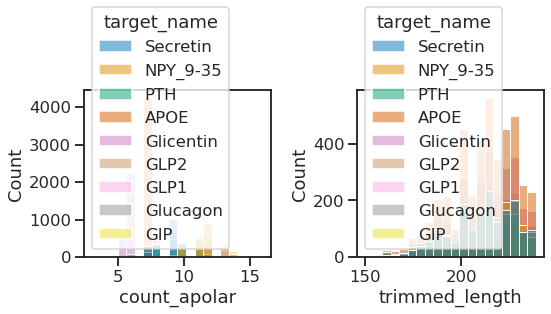

In [36]:
to_plot = [
    "count_apolar",
    "trimmed_length",
]

cols = [col for col in sorted(scores_df.columns) if col in to_plot]

the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    hue="target_name",
    stat="count",
    common_norm=False,
    bins=20,
)
# plt.tight_layout()
plt.savefig(os.path.join(output_path, "count_apolar_by_target.png"))

<Figure size 2160x2160 with 0 Axes>

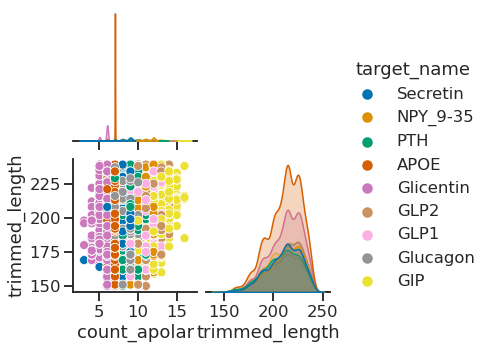

In [35]:
the_fig = pairplot_df(
    df=scores_df,
    cols=cols,
    hue="target_name",
    figsize=(30, 30),
)
# plt.tight_layout()
plt.savefig(os.path.join(output_path, "count_apolar_by_target_paired.png"))

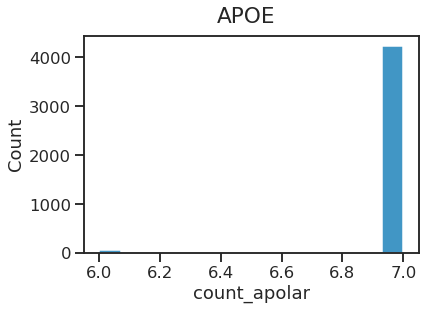

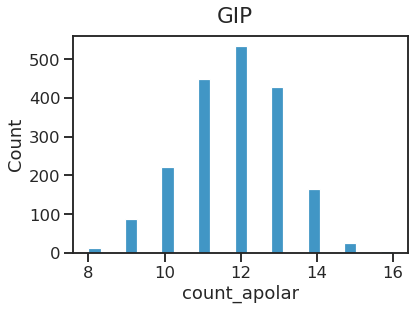

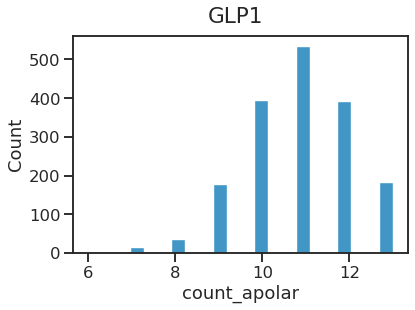

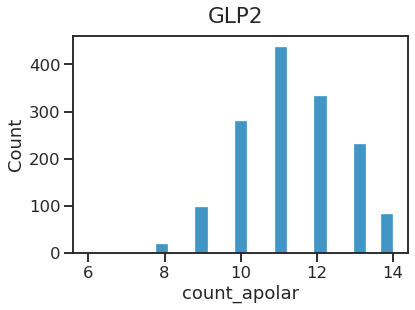

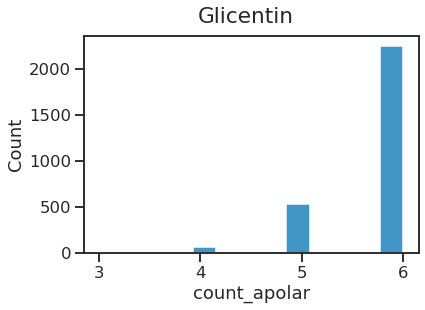

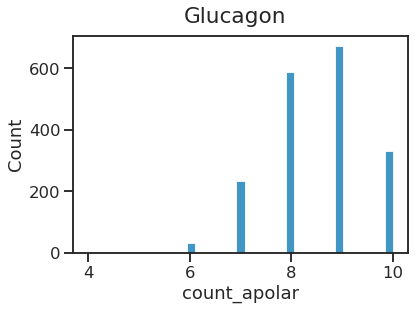

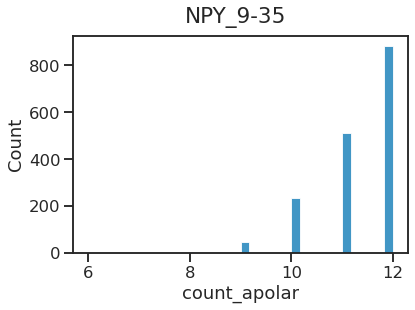

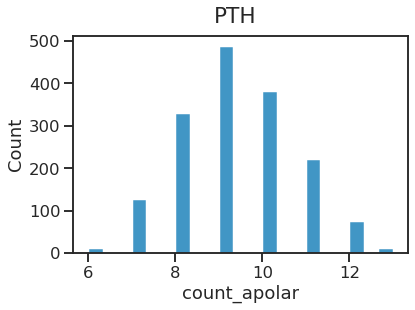

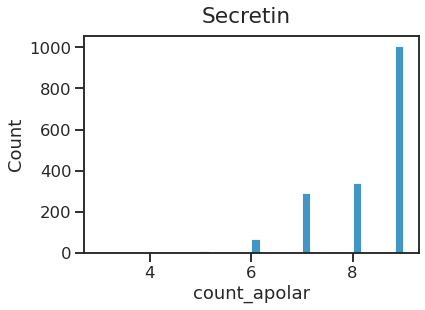

In [48]:
for target in sorted(set(scores_df.target_name.values)):
    fig, ax = plt.subplots()
    sns.histplot(
        ax=ax, x="count_apolar", data=scores_df.query(f"target_name == '{target}'")
    )
    plt.suptitle(target)

### Prototyping blocks

test `thread_target`

In [ ]:
%%time 
import pyrosetta

pyrosetta.init(
    "-mute all"
)


sys.path.insert(0, "/projects/crispy_shifty/")
from projects.crispy_crispies.deployables import thread_target

t = thread_target(
    None,
    pdb_path = "/projects/crispy_shifty/projects/crispy_shifty_junctions/03_fold_bound_states/decoys/0232/03_fold_bound_states_9afabc356b124965a06c1434779bdf34.pdb.bz2",
)
for i, pose in enumerate(t):
    print(pose.scores)